In [1]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
random_state = 12345
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines import CoxPHFitter


In [2]:
# Read train data
X_train = pd.read_csv("IDA_2024/train_operational_readouts.csv")
X_train_spec = pd.read_csv("IDA_2024/train_specifications.csv")
X_train_tte = pd.read_csv("IDA_2024/train_tte.csv")


Encoded categorical data

In [3]:
spec_encoded = pd.get_dummies(X_train_spec)
spec_encoded = spec_encoded.replace({False: 0, True: 1}) 

C:\Users\moka6903\AppData\Local\Temp\11\ipykernel_6616\1166156367.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spec_encoded = spec_encoded.replace({False: 0, True: 1})


In [4]:
categorical_col = spec_encoded.columns[1:]
numerical_col = X_train.columns[2:]

Using last read out

In [5]:
# Select maximum cycle
max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)
X_train_max_cycle = X_train[X_train["time_step"] == max_cycle].reset_index()
X_train_max_cycle.drop(columns='index', axis = 1, inplace= True)

C:\Users\moka6903\AppData\Local\Temp\11\ipykernel_6616\1431256340.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)


Merging three datasets

In [6]:
df_train = pd.merge(X_train_tte , X_train_max_cycle , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged=  pd.merge(df_train, spec_encoded , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged.isna().sum().sum()

11675

Missing value is filled with their above row value by ffill

In [7]:
dataset_ffil = dataset_merged.bfill(axis = 0)
dataset_ffil.isna().sum().sum()

0

In [8]:
# Create status column
dataset_ffil['status'] = dataset_ffil['in_study_repair'].apply(lambda x: False if x == 0 else True)
# Distribution of each status
print('X_train value_counts',dataset_ffil['status'].value_counts())

X_train value_counts status
False    21278
True      2272
Name: count, dtype: int64


In [9]:
dataset_ffil['RUL'] = dataset_ffil['length_of_study_time_step'] - dataset_ffil['time_step']

In [10]:
target_column = 'RUL'
df = dataset_ffil[list(numerical_col) + list(categorical_col) + ['RUL']].copy()



In [11]:
# Compute the correlation matrix
correlation_matrix = df.corrwith(df[target_column]).abs()
# Filter out correlations below the threshold
threshold = 0.01
filtered_correlations = correlation_matrix[correlation_matrix.abs() <= threshold]
# Sort the remaining correlations in ascending order
sorted_correlations = filtered_correlations.sort_values()
least_correlated_features = sorted_correlations.index.tolist()
# Print the least correlated features
print("Least correlated features:")
print(least_correlated_features)


Least correlated features:
['Spec_2_Cat5', 'Spec_7_Cat8', 'Spec_6_Cat10', 'Spec_1_Cat12', 'Spec_1_Cat19', 'Spec_1_Cat16', 'Spec_6_Cat13', 'Spec_2_Cat4', 'Spec_2_Cat13', '291_0', 'Spec_1_Cat24', 'Spec_1_Cat6', 'Spec_3_Cat2', '158_0', 'Spec_1_Cat15', 'Spec_1_Cat18', 'Spec_6_Cat18', 'Spec_2_Cat11', 'Spec_2_Cat15', 'Spec_1_Cat3', '397_23', '397_11', '397_28', '291_7', '397_22', '397_10', '397_29', 'Spec_6_Cat6', '397_9', 'Spec_6_Cat8', 'Spec_2_Cat20', 'Spec_1_Cat25', '397_4', '397_16', 'Spec_1_Cat4', 'Spec_5_Cat2', '291_8', '397_15', '291_9', 'Spec_1_Cat9', '397_21', '291_6', '397_12', 'Spec_1_Cat27', '291_1', '397_17', '459_17', '291_10', '291_2', 'Spec_3_Cat0', 'Spec_0_Cat0', '397_2', 'Spec_2_Cat7', 'Spec_2_Cat12', 'Spec_2_Cat3', 'Spec_1_Cat10', 'Spec_1_Cat23', '397_14', '459_19', 'Spec_6_Cat15', 'Spec_2_Cat18', 'Spec_5_Cat1', '397_7', 'Spec_1_Cat22', '397_3', '397_6', 'Spec_0_Cat1', 'Spec_1_Cat7', 'Spec_2_Cat19', 'Spec_2_Cat6', 'Spec_1_Cat11', '397_19', 'Spec_5_Cat0', 'Spec_5_Cat3', '39

In [12]:

dataset_droped_corr = dataset_ffil.drop(columns= least_correlated_features, inplace = False)
dataset_droped_corr

vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
0               0                      510.0                0      507.4   
1               2                      281.8                0      281.0   
2               3                      293.4                0      291.2   
3               4                      210.0                0      203.0   
4               5                      360.4                0      357.6   
...           ...                        ...              ...        ...   
23545       33639                      137.4                0      112.6   
23546       33640                      124.6                0      123.2   
23547       33641                      123.0                0      116.0   
23548       33642                      126.6                0      126.4   
23549       33643                      130.2                0      125.8   

            171_0     666_0        427_0     837_0    167_0      167_1  ...  \
0      10189950.0  372685.0  233978571.0   41670.0  10415.0  9137870.0  ...   
1       5648790.0  289371.0  233978571.0   68717.0  10415.0  9137870.0  ...   
2       7603590.0  230831.0  273813365.0  100121.0   5918.0  8225139.0  ...   
3       4842780.0  210381.0  174662976.0  152385.0   7128.0  4342398.0  ...   
4       6623040.0  280531.0  246994778.0  164673.0   2688.0  6438153.0  ...   
...           ...       ...          ...       ...      ...        ...  ...   
23545   2894100.0   75859.0   98975802.0   10040.0   6631.0  5229663.0  ...   
23546   3925455.0  138179.0  139017335.0   35726.0  15397.0  5757292.0  ...   
23547   2567085.0  118371.0   91726867.0    9122.0   6783.0  3383972.0  ...   
23548   3350700.0   80078.0  118733863.0   11251.0    755.0  9392926.0  ...   
23549   2741460.0   52949.0  104122894.0   15222.0    843.0  7988418.0  ...   

       Spec_6_Cat9  Spec_7_Cat0  Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat4  \
0                0            1            0            0            0   
1                0            0            1            0            0   
2                0            0            1            0            0   
3                0            0            1            0            0   
4                0            0            1            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            0            1   
23546            0            0            0            0            1   
23547            0            0            0            0            1   
23548            0            0            0            0            1   
23549            0            0            0            0            1   

       Spec_7_Cat5  Spec_7_Cat6  Spec_7_Cat7  status   RUL  
0                0            0            0   False   2.6  
1                0            0            0   False   0.8  
2                0            0            0   False   2.2  
3                0            0            0   False   7.0  
4                0            0            0   False   2.8  
...            ...          ...          ...     ...   ...  
23545            0            0            0   False  24.8  
23546            0            0            0   False   1.4  
23547            0            0            0   False   7.0  
23548            0            0            0   False   0.2  
23549            0            0            0   False   4.4  

[23550 rows x 108 columns]

we droped the least corrolated features with RUL

In [13]:

df2 = dataset_droped_corr.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id', 'status','RUL'], axis = 1)

# Define the correlation threshold
correlation_threshold = 0.9
correlation_matrix = df2.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = np.triu(correlation_matrix, k=1)

# Find the indices where the correlation exceeds the threshold
high_correlation_indices = np.where(upper_triangle > correlation_threshold)

# Initialize a list to store pairs of highly correlated variables
high_correlation_pairs = []
high_correlation_features = []

# Iterate through the indices and extract the variable pairs
for i, j in zip(high_correlation_indices[0], high_correlation_indices[1]):
    variable_i = correlation_matrix.index[i]
    variable_j = correlation_matrix.columns[j]
    correlation_value = correlation_matrix.iloc[i, j]
    high_correlation_pairs.append((variable_i, variable_j, correlation_value))
    high_correlation_features.append(variable_i)

# Print the highly correlated variable pairs
print("Highly Correlated Variable Pairs:")
for pair in high_correlation_pairs:
    print(pair)
print( list(set(high_correlation_features)))

Highly Correlated Variable Pairs:
('171_0', '427_0', 0.9730007497452052)
('171_0', '167_5', 0.9460448609594139)
('171_0', '158_4', 0.9262147919807299)
('427_0', '167_5', 0.9382254164771827)
('427_0', '835_0', 0.9303269247821015)
('427_0', '158_4', 0.9128112793731821)
('167_1', '272_0', 0.9400816811370624)
('167_5', '158_4', 0.9001366810567631)
('835_0', '158_2', 0.9104151987804896)
('291_4', '291_5', 0.932067975608117)
('158_4', '158_5', 0.9117096484768004)
('158_5', '158_6', 0.9705508849684782)
('158_5', '397_20', 0.9027896509711755)
('158_6', '158_7', 0.9097054380177748)
('158_6', '397_26', 0.906111555668511)
('158_8', '397_32', 0.9001561683485353)
('459_2', '459_3', 0.9621184433854746)
('459_2', '459_4', 0.9132452923656494)
('459_3', '459_4', 0.9757330762892937)
('459_3', '459_5', 0.936554709077647)
('459_4', '459_5', 0.9801950466014356)
('459_4', '459_6', 0.9295318585796065)
('459_5', '459_6', 0.9736551689124806)
('459_5', '459_7', 0.920422411187694)
('459_6', '459_7', 0.9708841383

In [14]:

main_data1 = dataset_droped_corr.drop(columns= list(set(high_correlation_features)))
main_data =main_data1.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id'], axis = 1)
main_data

666_0     837_0    167_0       167_2       167_3       167_4  \
0      372685.0   41670.0  10415.0  74655621.0  45991626.0  65888583.0   
1      289371.0   68717.0  10415.0  74655621.0  45991626.0  65888583.0   
2      230831.0  100121.0   5918.0  17004223.0  10504195.0  30792854.0   
3      210381.0  152385.0   7128.0  13348382.0  11538870.0  30085352.0   
4      280531.0  164673.0   2688.0  13604867.0  14694395.0  41110339.0   
...         ...       ...      ...         ...         ...         ...   
23545   75859.0   10040.0   6631.0  10519563.0   8797533.0  27117757.0   
23546  138179.0   35726.0  15397.0  11640261.0   7568543.0  19594203.0   
23547  118371.0    9122.0   6783.0   6551850.0   6232055.0  17999988.0   
23548   80078.0   11251.0    755.0  16152271.0   7956861.0  17692205.0   
23549   52949.0   15222.0    843.0  16274631.0   8095988.0  20056805.0   

            167_6      167_7     167_8     167_9  ...  Spec_6_Cat9  \
0       5813857.0     3351.0       0.0       0.0  ...            0   
1       5813857.0     3351.0       0.0       0.0  ...            0   
2      27370868.0  3819383.0  293456.0  101162.0  ...            0   
3      53625651.0  1225967.0    7593.0       0.0  ...            0   
4      15011017.0   689121.0   43760.0   13999.0  ...            0   
...           ...        ...       ...       ...  ...          ...   
23545   6053328.0    32612.0       0.0       0.0  ...            0   
23546  48183109.0  1682930.0   52639.0       0.0  ...            0   
23547  12452989.0   108785.0       0.0       0.0  ...            0   
23548   9509643.0   483602.0    2240.0       0.0  ...            0   
23549  13475823.0  1127331.0   84195.0    6380.0  ...            0   

       Spec_7_Cat0  Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat4  Spec_7_Cat5  \
0                1            0            0            0            0   
1                0            1            0            0            0   
2                0            1            0            0            0   
3                0            1            0            0            0   
4                0            1            0            0            0   
...            ...          ...          ...          ...          ...   
23545            0            0            0            1            0   
23546            0            0            0            1            0   
23547            0            0            0            1            0   
23548            0            0            0            1            0   
23549            0            0            0            1            0   

       Spec_7_Cat6  Spec_7_Cat7  status   RUL  
0                0            0   False   2.6  
1                0            0   False   0.8  
2                0            0   False   2.2  
3                0            0   False   7.0  
4                0            0   False   2.8  
...            ...          ...     ...   ...  
23545            0            0   False  24.8  
23546            0            0   False   1.4  
23547            0            0   False   7.0  
23548            0            0   False   0.2  
23549            0            0   False   4.4  

[23550 rows x 80 columns]

Split to train and test, 80/20

In [15]:
x_train, x_test, y_train, y_test = train_test_split(shuffle(main_data), main_data['status'], test_size=0.2, random_state= random_state, stratify= main_data['status'])


Train X and Train y

In [16]:
# Preprocessing for target variable for train dataset
train_y = list(x_train.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
train_y = np.array(train_y, dtype=[('status', bool), ('RUL', float)])
train_X = x_train.drop(columns= ['RUL','status'], axis = 1)
train_y

array([(False, 0.8), (False, 4.8), (False, 1. ), ..., (False, 1.8),
       (False, 6.6), (False, 0.4)],
      dtype=[('status', '?'), ('RUL', '<f8')])

In [17]:
# Preprocessing for target variable for test dataset
test_y = list(x_test.loc[:, ["status", "RUL"]].itertuples(index = None, name = None))
test_y = np.array(test_y, dtype=[('status', bool), ('RUL', float)])
test_X = x_test.drop(columns= ['RUL','status'], axis = 1)
test_y

array([(False, 0.8), (False, 0.4), ( True, 1.2), ..., (False, 0.2),
       (False, 2.2), (False, 1.2)],
      dtype=[('status', '?'), ('RUL', '<f8')])

In [18]:
rsf = RandomSurvivalForest(
    n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state
)
rsf.fit(train_X, train_y)

RandomSurvivalForest(max_depth=30, max_features='log2', min_samples_leaf=10,
                     min_samples_split=30, n_estimators=200, n_jobs=-1,
                     random_state=12345)

In [19]:
rsf.score(train_X, train_y)

0.9443866084993487

In [20]:
rsf.score(test_X, test_y)

0.7124806794698858

Survival analysis

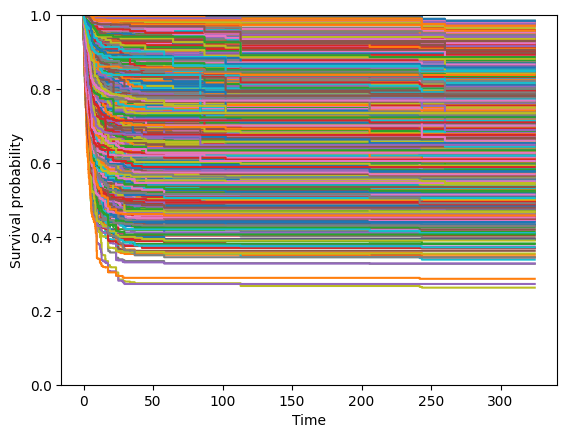

In [21]:
surv_funcs = rsf.predict_survival_function(test_X)
for fn in surv_funcs:
     plt.step(fn.x, fn(fn.x), where="post")

#sns.set(rc = {'figure.figsize':(20,20)})
plt.ylabel("Survival probability")
plt.xlabel("Time")
plt.ylim(0, 1)
plt.show()

SHAP analysis

In [23]:
import shap
from sklearn.ensemble import RandomForestRegressor

X_testt = test_X
X_trainn = train_X

# Convert RandomSurvivalForest to a RandomForestRegressor (surrogate model)
# using the predicted survival times as the target variable
surrogate_model = RandomForestRegressor(n_estimators=200, max_depth= 30, max_features='log2',  min_samples_split=30, min_samples_leaf=10, n_jobs = -1, random_state=random_state)
surrogate_model.fit(X_trainn, rsf.predict(X_trainn))

# Create a SHAP explainer for the surrogate model
explainer = shap.Explainer(surrogate_model, X_trainn)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


100%|===================| 4703/4710 [08:17<00:00]        

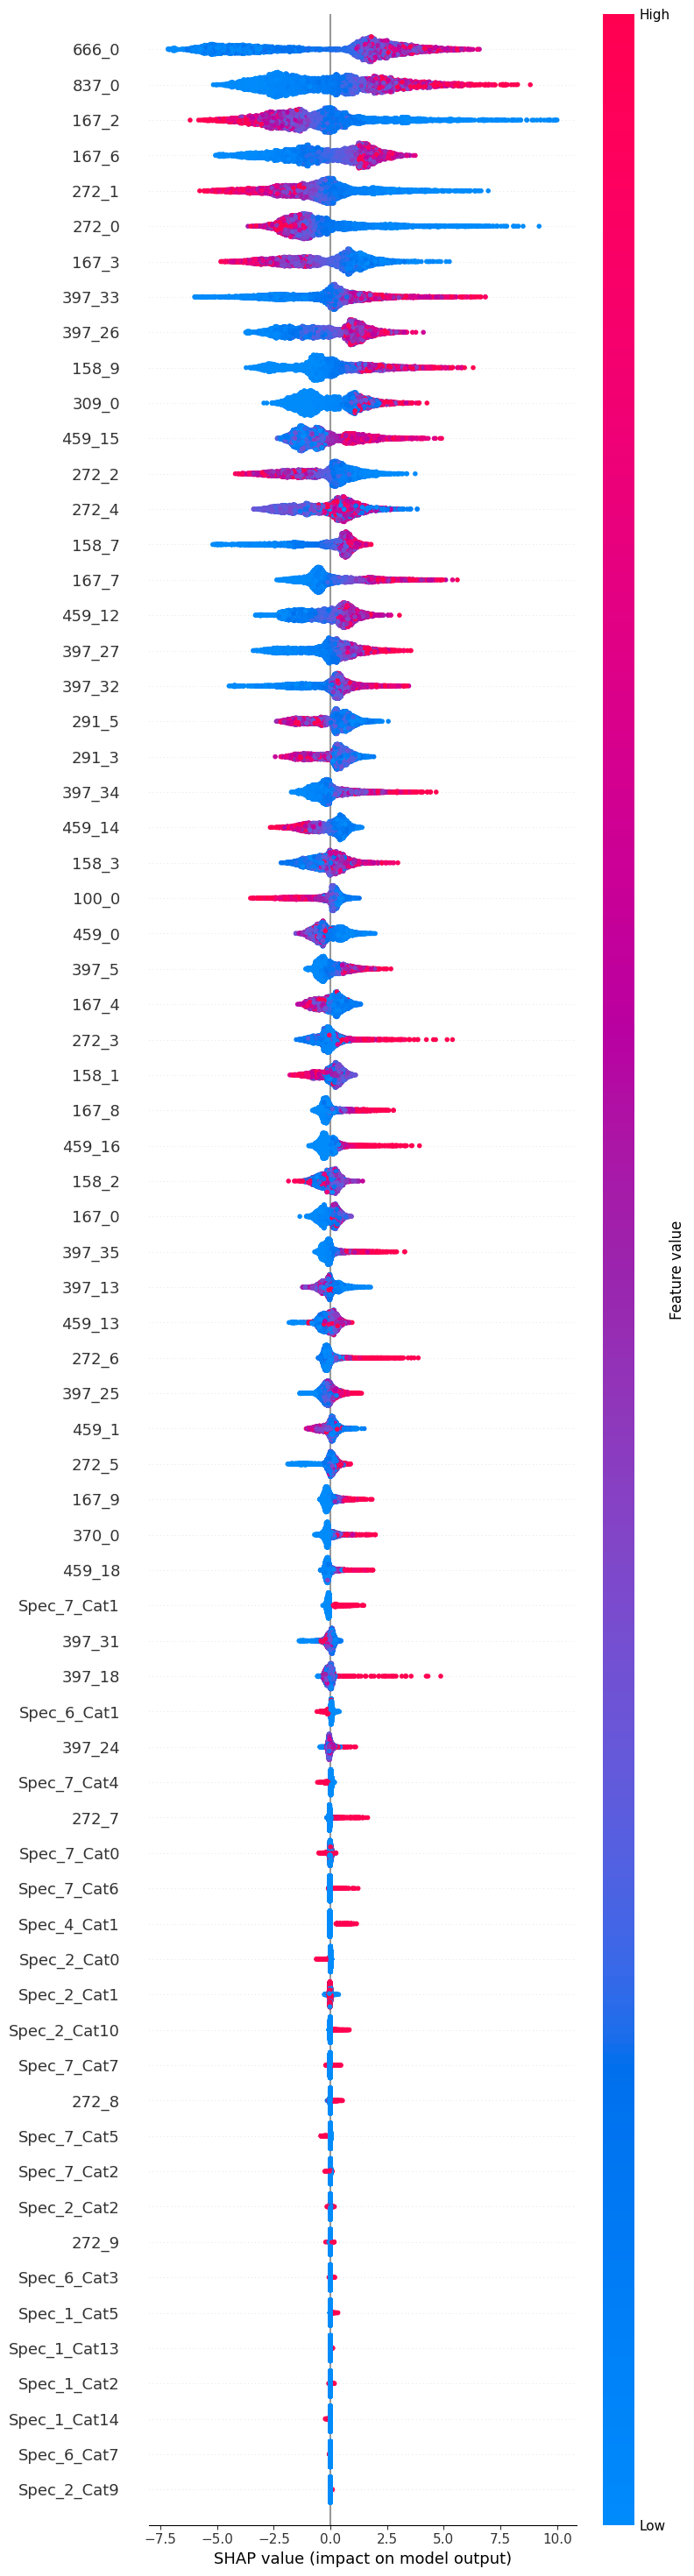

In [36]:
#Global Explanation
shap_values = explainer.shap_values(X_testt)
shap.summary_plot(shap_values, X_testt, max_display=70 )

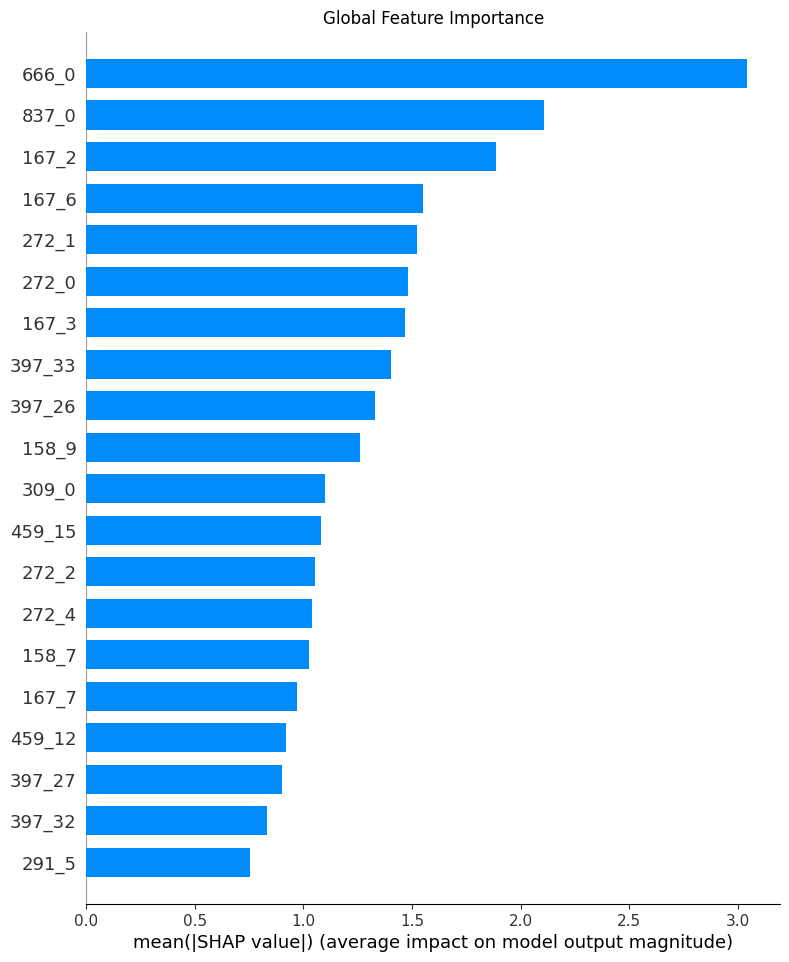

In [37]:
shap.summary_plot(shap_values, X_testt, plot_type='bar', show=False)
plt.title('Global Feature Importance')
plt.show()

Healthy category

Indices of instances whose survival probability are above 90% within the first 50 time points: [7, 15, 27, 29, 35, 36, 38, 43, 45, 47, 62, 65, 67, 90, 93, 111, 119, 127, 148, 160, 165, 166, 176, 185, 188, 189, 193, 194, 203, 207, 211, 213, 220, 227, 228, 232, 242, 245, 247, 250, 253, 269, 270, 271, 289, 297, 312, 320, 327, 329, 333, 340, 345, 357, 362, 370, 371, 374, 375, 391, 392, 394, 401, 404, 408, 415, 416, 418, 422, 435, 440, 451, 471, 494, 523, 539, 563, 568, 572, 576, 578, 586, 607, 613, 619, 622, 629, 635, 637, 640, 646, 654, 656, 657, 668, 669, 678, 685, 687, 689, 694, 710, 735, 736, 753, 763, 767, 779, 781, 802, 816, 818, 833, 835, 836, 859, 884, 898, 933, 939, 943, 955, 959, 963, 965, 982, 987, 993, 996, 1008, 1026, 1028, 1033, 1040, 1043, 1056, 1069, 1077, 1082, 1089, 1091, 1097, 1099, 1104, 1110, 1121, 1131, 1132, 1143, 1145, 1148, 1149, 1150, 1153, 1157, 1166, 1169, 1171, 1192, 1193, 1197, 1211, 1222, 1231, 1233, 1241, 1249, 1267, 1275, 1285, 1294, 1297, 1308, 1313, 1316,

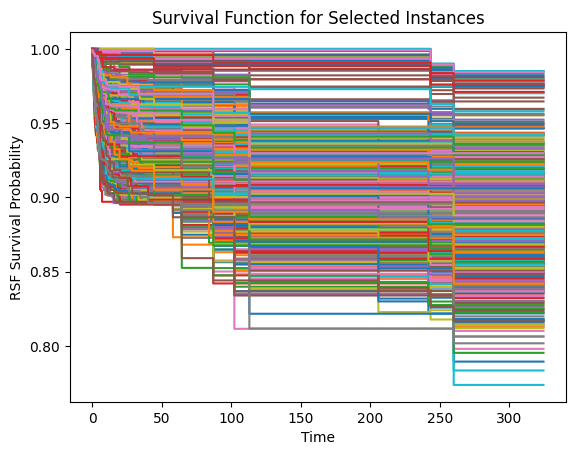

In [47]:
indices_fall_to_one = []
# Predict survival probabilities for all instances in the test set
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_50 = survival_func(50)
    survival_prob_at_50_rounded = round(survival_prob_at_50, 2)
    if survival_prob_at_50_rounded >= 0.9:
        indices_fall_to_one.append(i)

print("Indices of instances whose survival probability are above 90% within the first 50 time points:", indices_fall_to_one)
indices_to_plot = indices_fall_to_one  # Replace with your array of indices

# Iterate over the array of indices
for index in indices_to_plot:
    survival_func_to_plot = surv_funcs[index]
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for Selected Instances")
#plt.legend()
plt.show()

 99%|===================| 600/607 [01:11<00:00]        

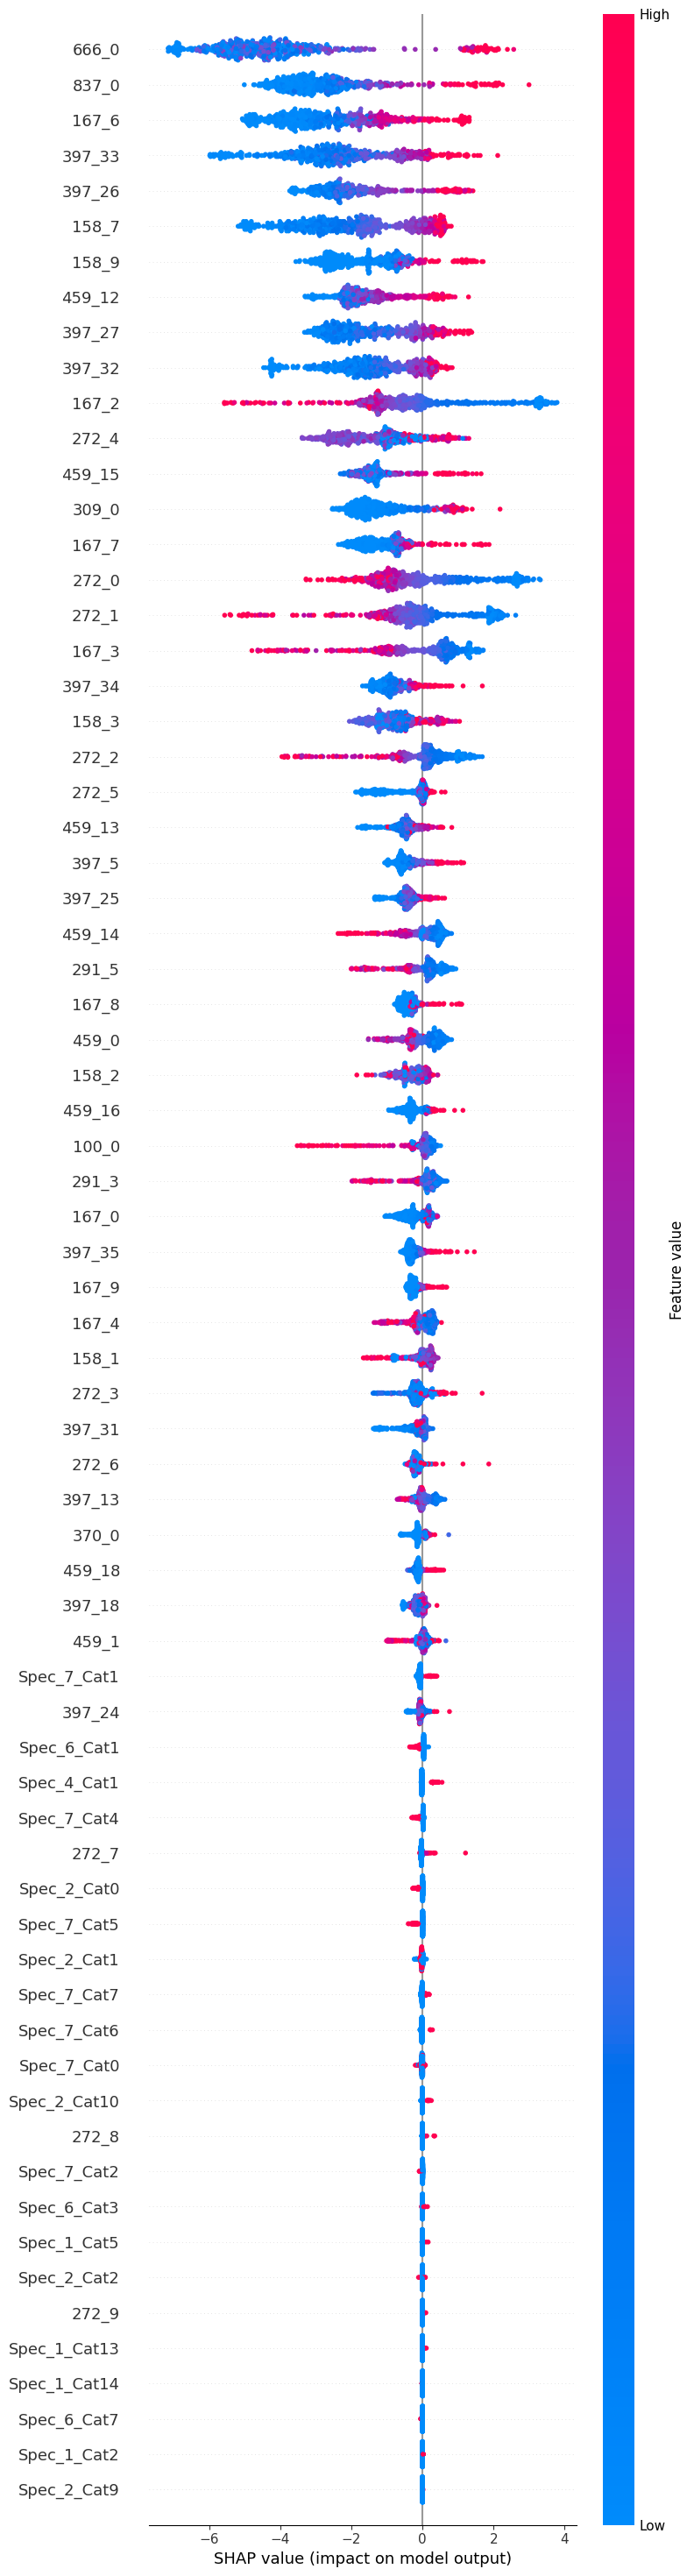

In [28]:
X_test_healthy = test_X.iloc[indices_fall_to_one]
shap_values_healthy = explainer.shap_values(X_test_healthy)
shap.summary_plot(shap_values_healthy, X_test_healthy, max_display=70 )

Loca Explanation_from Healthy category

    vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
47          70                      467.6                0      467.2   

        171_0     666_0        427_0     837_0    167_0       167_1  ...  \
47  8819430.0  449192.0  344664619.0  183565.0  42946.0  16446475.0  ...   

    Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
47            1            0            0            0            0   

    Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status  RUL  
47            0            0            0   False  0.4  

[1 rows x 201 columns]


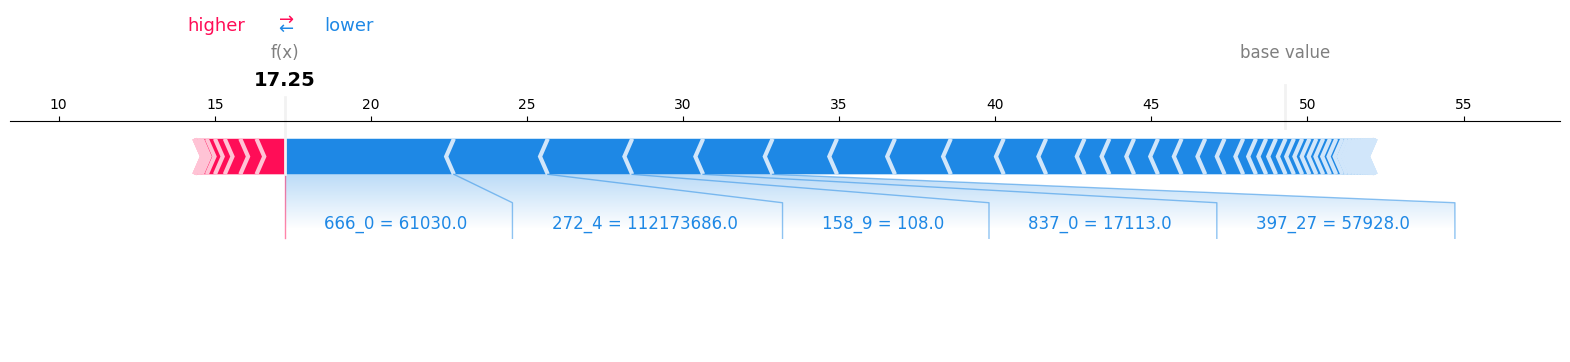

In [33]:
print(dataset_ffil[dataset_ffil.index == 47])
instance_index = 47
instance = X_testt.iloc[instance_index]  # Get the instance from the test set
    
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values_healthy[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

Medium category

Indices of instances whose survival probability are btw 80% and 60 % within the first 50 time points: [0, 1, 4, 5, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 26, 30, 32, 33, 34, 40, 42, 46, 48, 50, 51, 53, 54, 56, 57, 59, 60, 61, 66, 68, 71, 73, 75, 77, 79, 81, 85, 86, 87, 89, 91, 92, 95, 98, 99, 100, 101, 102, 106, 107, 108, 110, 112, 114, 115, 117, 118, 122, 123, 124, 125, 131, 135, 137, 138, 141, 149, 152, 153, 154, 156, 157, 159, 162, 163, 164, 167, 168, 170, 171, 172, 173, 174, 177, 178, 179, 180, 181, 182, 184, 187, 191, 196, 197, 199, 201, 202, 204, 205, 206, 209, 210, 212, 214, 215, 216, 218, 224, 225, 229, 231, 234, 235, 236, 237, 238, 243, 246, 248, 249, 252, 254, 255, 258, 259, 260, 261, 265, 266, 274, 275, 276, 279, 280, 282, 283, 284, 286, 287, 288, 290, 293, 296, 298, 300, 302, 303, 305, 308, 309, 315, 316, 317, 318, 319, 324, 328, 331, 334, 336, 341, 342, 347, 348, 349, 351, 352, 356, 359, 363, 364, 365, 366, 368, 369, 373, 377, 379, 380, 382, 384, 386, 387, 388, 396, 3

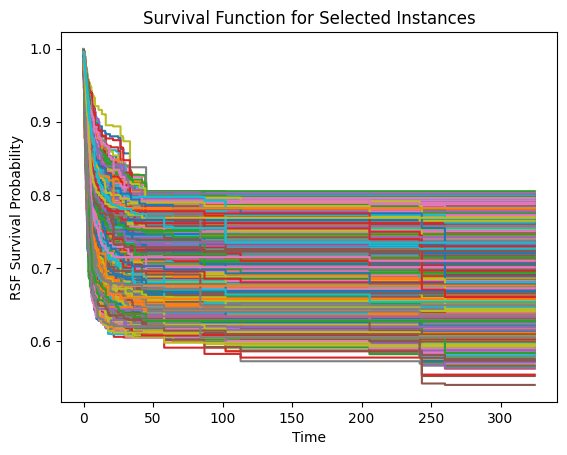

In [48]:
indices_eighty_to_sixty = []
# Predict survival probabilities for all instances in the test set
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_50 = survival_func(50)
    survival_prob_at_50_rounded = round(survival_prob_at_50, 2)
    if (survival_prob_at_50_rounded > 0.6) & (survival_prob_at_50_rounded <= 0.8) :
        indices_eighty_to_sixty.append(i)

print("Indices of instances whose survival probability are btw 80% and 60 % within the first 50 time points:", indices_eighty_to_sixty)
indices_to_plot = indices_eighty_to_sixty  

# Iterate over the array of indices
for index in indices_to_plot:
    # Get the survival function for the selected index
    survival_func_to_plot = surv_funcs[index]
    # Plot the survival function
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for Selected Instances")
#plt.legend()
plt.show()

100%|===================| 2379/2380 [03:46<00:00]        

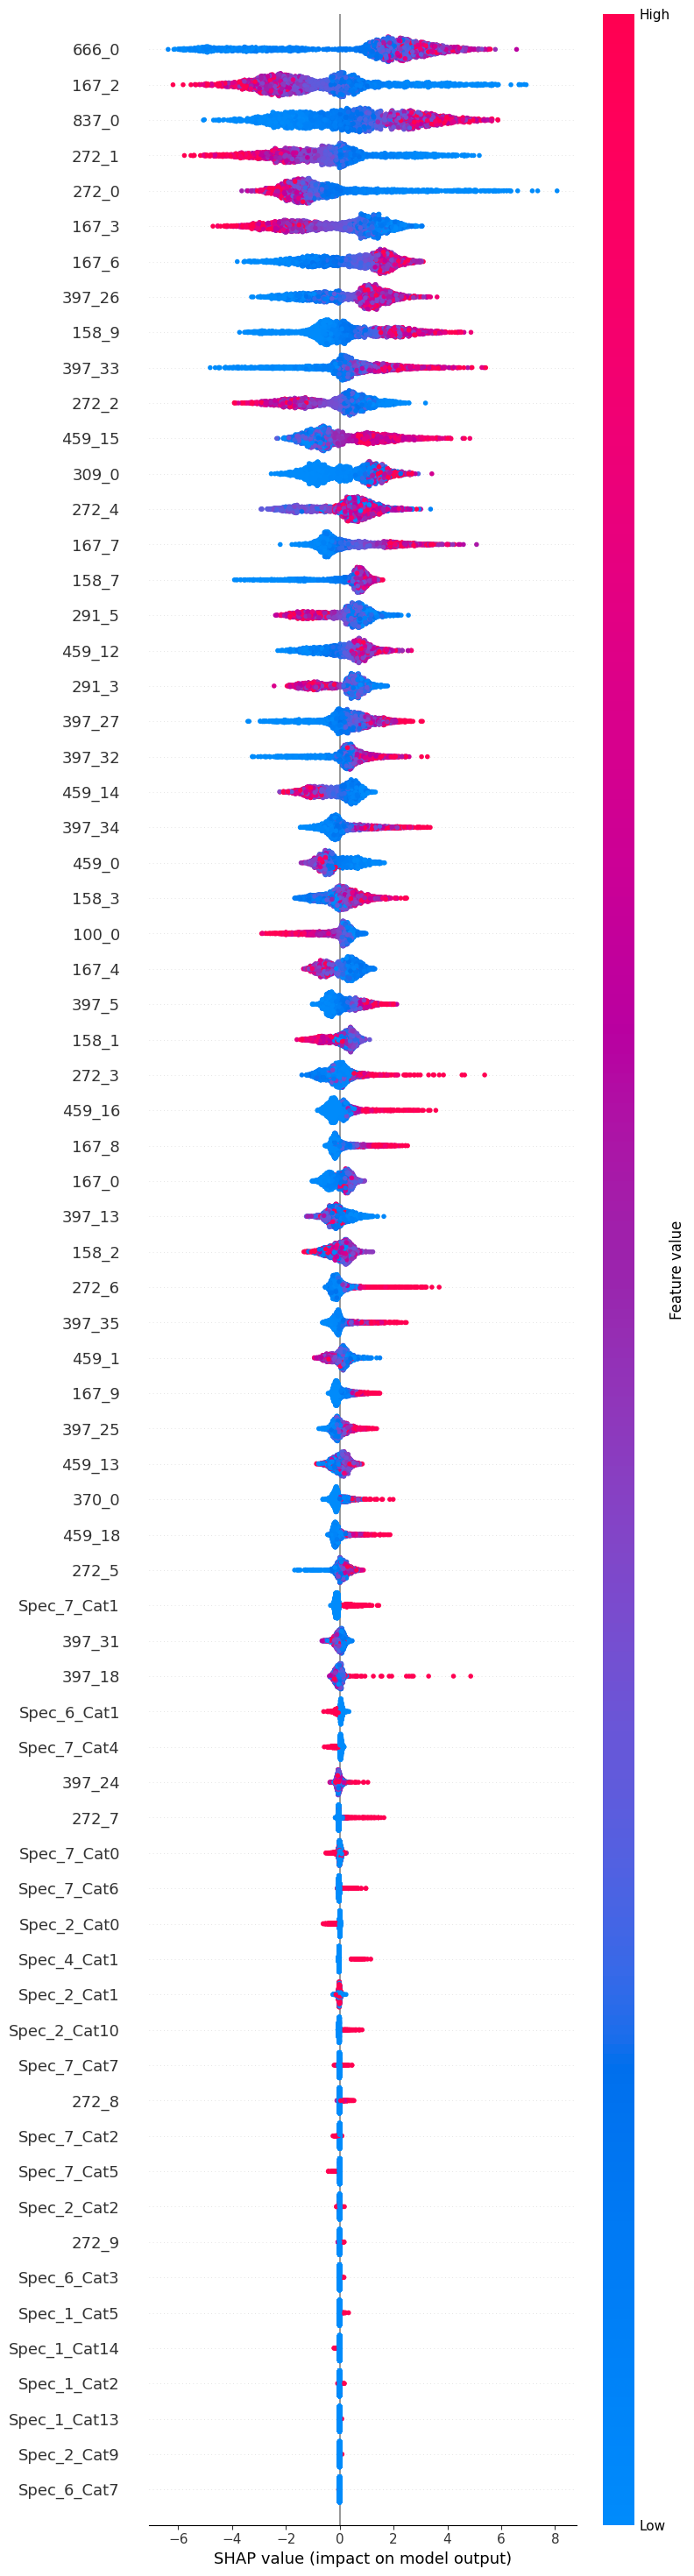

In [29]:
X_test_medium = test_X.iloc[indices_eighty_to_sixty]
shap_values_medium = explainer.shap_values(X_test_medium)
shap.summary_plot(shap_values_medium, X_test_medium, max_display=70 )

Local Explaination for medium

    vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
24          39                      436.8                0      426.6   

        171_0     666_0        427_0     837_0    167_0       167_1  ...  \
24  8936055.0  233626.0  328137837.0  116368.0  58890.0  18871138.0  ...   

    Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
24            1            0            0            0            0   

    Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status   RUL  
24            0            0            0   False  10.2  

[1 rows x 201 columns]


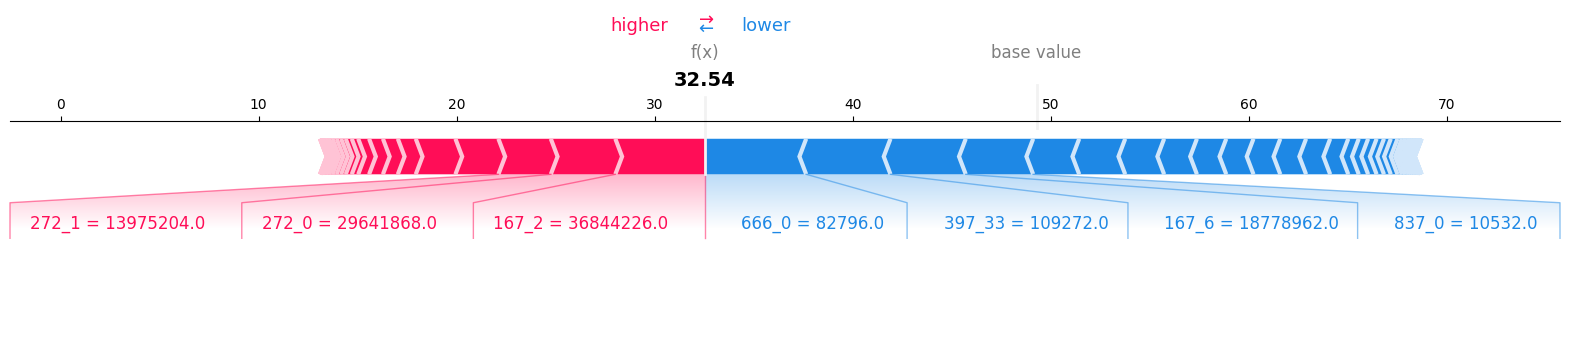

In [34]:
print(dataset_ffil[dataset_ffil.index == 24])
instance_index = 24
instance = X_testt.iloc[instance_index]  # Get the instance from the test set 
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values_medium[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

Risky category

Indices of instances whose survival probability are bellow 60% within the first 50 time points: [2, 52, 63, 82, 97, 109, 133, 158, 195, 198, 208, 222, 223, 241, 263, 281, 285, 299, 310, 311, 313, 323, 338, 353, 367, 372, 383, 385, 390, 402, 414, 419, 432, 450, 458, 467, 470, 477, 491, 495, 520, 522, 527, 547, 567, 582, 603, 604, 608, 611, 626, 662, 663, 679, 692, 722, 728, 745, 765, 766, 772, 782, 792, 793, 803, 824, 828, 838, 880, 893, 894, 896, 899, 936, 961, 977, 1006, 1032, 1038, 1045, 1046, 1049, 1076, 1079, 1117, 1119, 1124, 1130, 1138, 1163, 1177, 1178, 1225, 1239, 1243, 1248, 1270, 1333, 1347, 1364, 1365, 1405, 1417, 1420, 1442, 1451, 1461, 1469, 1475, 1497, 1505, 1511, 1515, 1516, 1518, 1528, 1529, 1557, 1597, 1605, 1606, 1613, 1618, 1639, 1643, 1651, 1677, 1678, 1691, 1696, 1702, 1716, 1741, 1745, 1749, 1762, 1765, 1774, 1776, 1782, 1783, 1793, 1805, 1807, 1810, 1813, 1828, 1841, 1843, 1862, 1865, 1905, 1909, 1920, 1921, 1925, 1935, 1940, 1950, 1958, 1994, 2004, 2015, 2023, 2

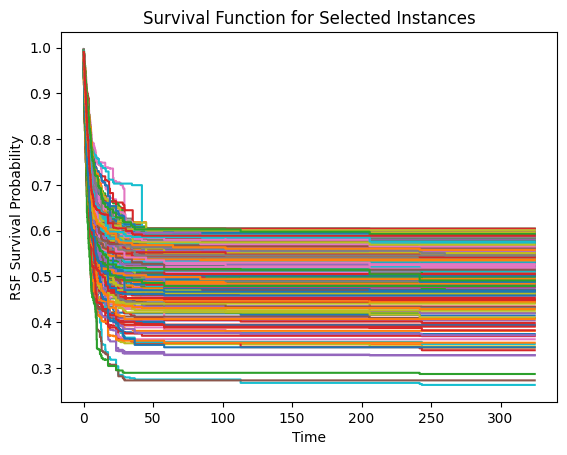

In [50]:
indices_fall_to_sixty = []
surv_funcs = rsf.predict_survival_function(test_X)

# Iterate over each instance
for i, survival_func in enumerate(surv_funcs):
    survival_prob_at_50 = survival_func(50)
    survival_prob_at_50_rounded = round(survival_prob_at_50, 2)
    if survival_prob_at_50_rounded <= 0.6:
        indices_fall_to_sixty.append(i)

print("Indices of instances whose survival probability are bellow 60% within the first 50 time points:", indices_fall_to_sixty)
indices_to_plot = indices_fall_to_sixty 
for index in indices_to_plot:
    survival_func_to_plot = surv_funcs[index]
    plt.step(survival_func_to_plot.x, survival_func_to_plot.y, where="post", label=f"Instance {index}")
plt.xlabel("Time")
plt.ylabel("RSF Survival Probability")
plt.title("Survival Function for Selected Instances")
#plt.legend()
plt.show()

100%|===================| 373/374 [00:36<00:00]        

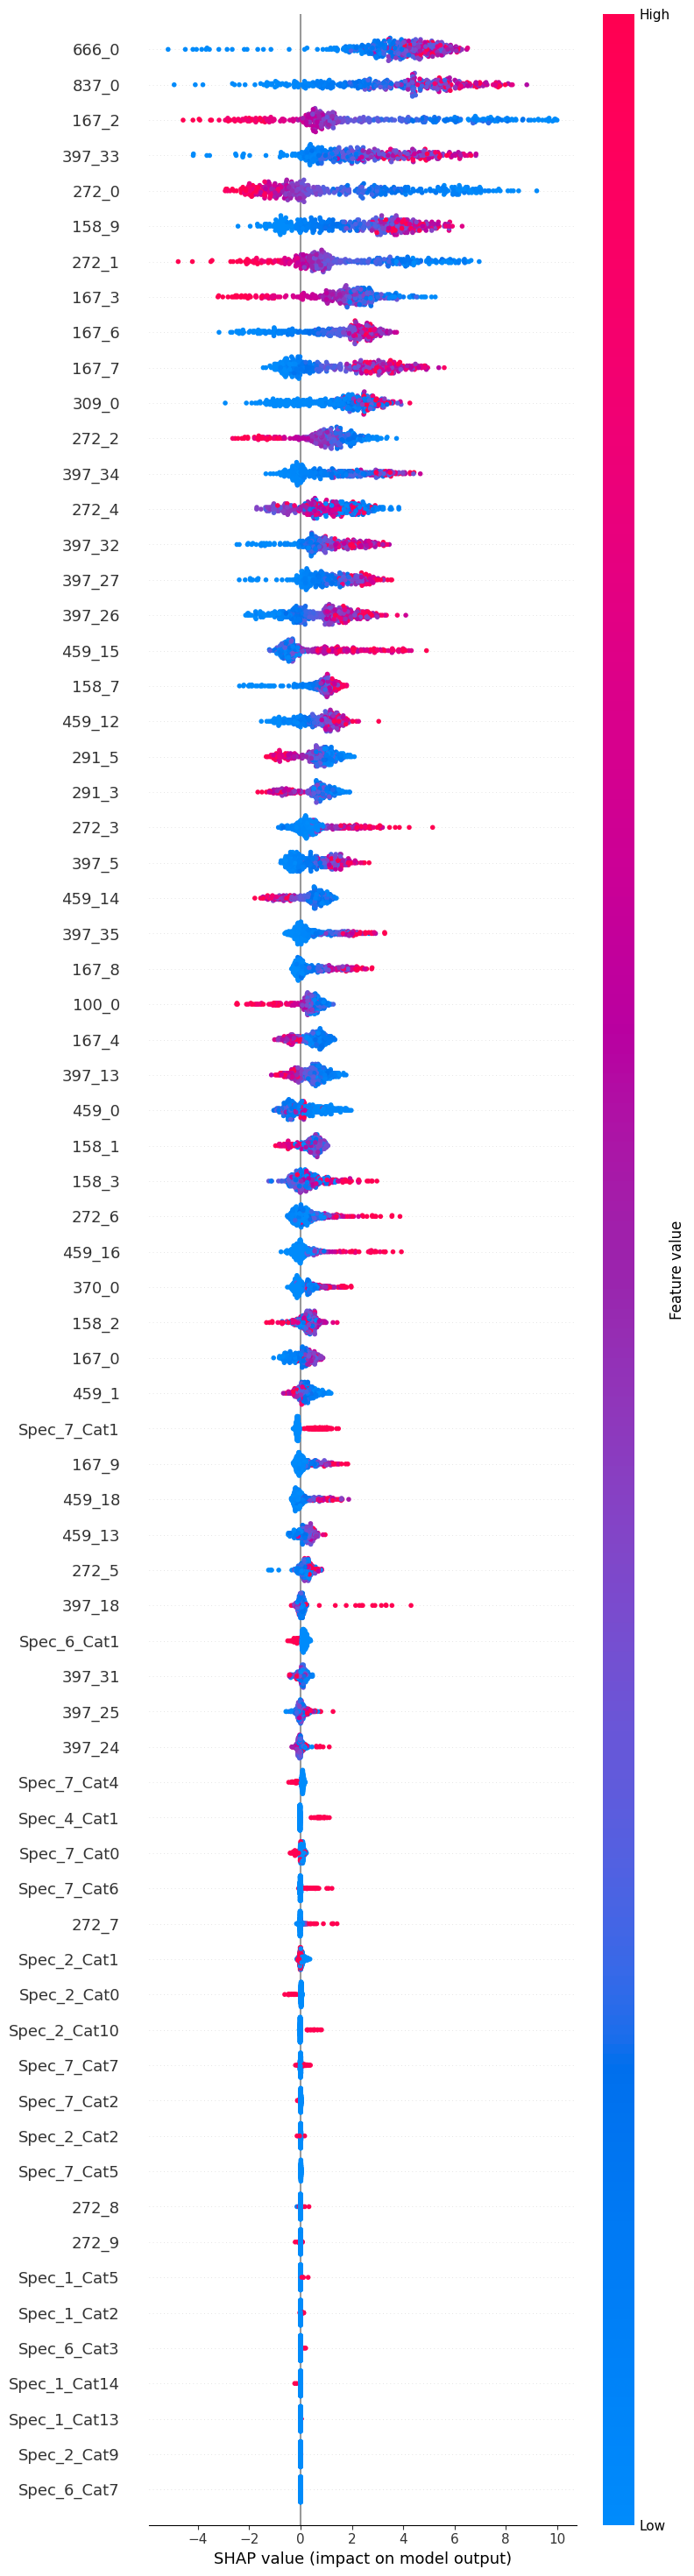

In [31]:
X_test_risky = test_X.iloc[indices_fall_to_sixty]
shap_values_risky = explainer.shap_values(X_test_risky)
shap.summary_plot(shap_values_risky, X_test_risky, max_display=70)

     vehicle_id  length_of_study_time_step  in_study_repair  time_step  \
158         219                      497.8                0      494.6   

         171_0     666_0        427_0     837_0   167_0       167_1  ...  \
158  8936235.0  318374.0  379720849.0  180708.0  8057.0  14896754.0  ...   

     Spec_7_Cat1  Spec_7_Cat2  Spec_7_Cat3  Spec_7_Cat4  Spec_7_Cat5  \
158            1            0            0            0            0   

     Spec_7_Cat6  Spec_7_Cat7  Spec_7_Cat8  status  RUL  
158            0            0            0   False  3.2  

[1 rows x 201 columns]


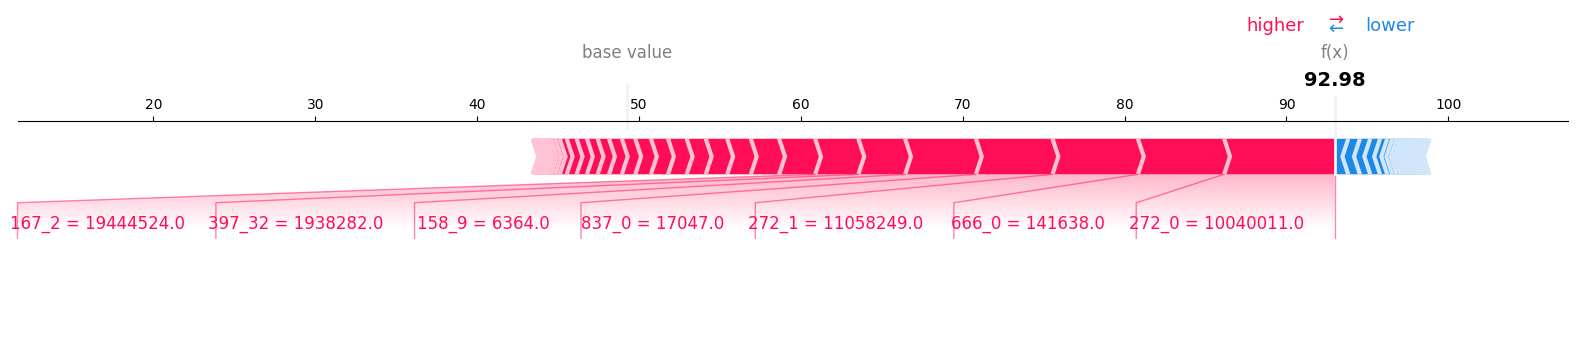

In [35]:
print(dataset_ffil[dataset_ffil.index == 158])
instance_index = 158
instance = X_testt.iloc[instance_index]  # Get the instance from the test set 
# Calculate SHAP values for the chosen instance
shap_values_instance = shap_values_risky[instance_index]
expected_value1 = explainer.expected_value
shap.initjs()
# Plot local SHAP force plot for the chosen instance
shap.force_plot(expected_value1, shap_values_instance, instance , matplotlib=True)

SHAP Dependence plots

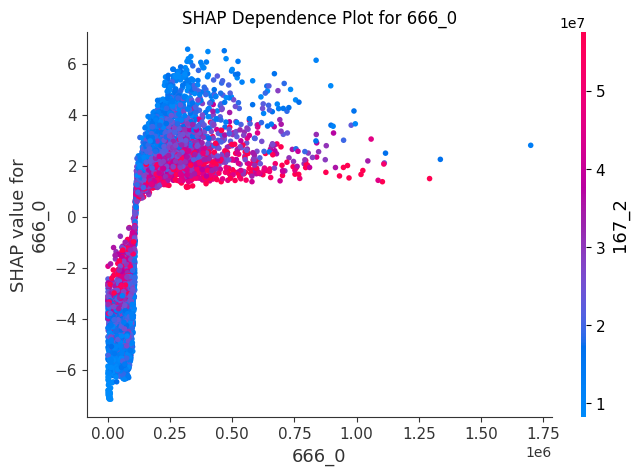

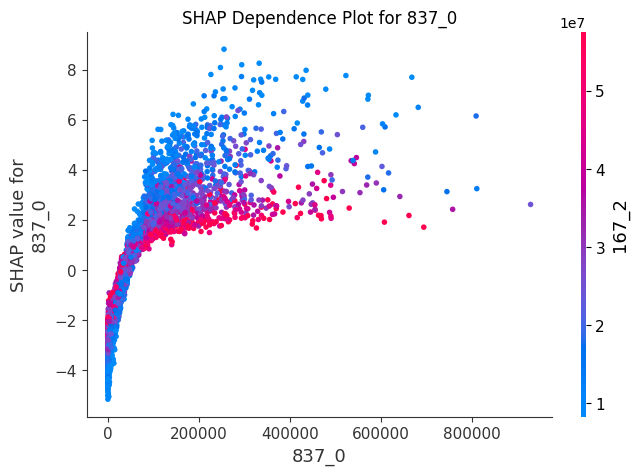

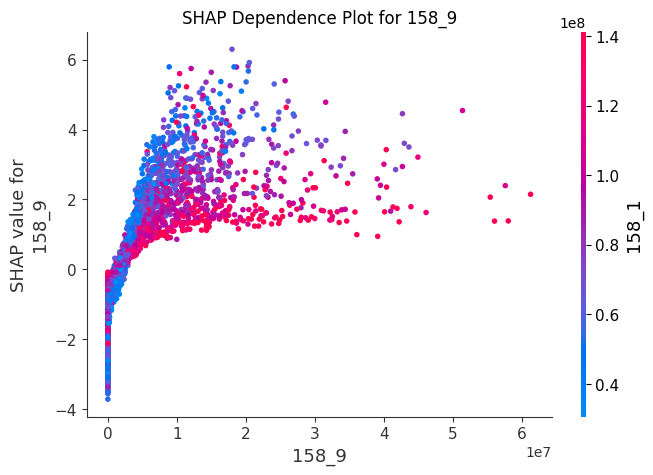

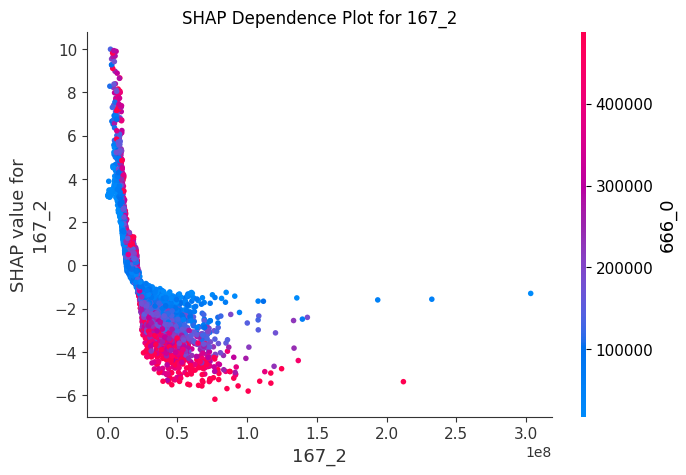

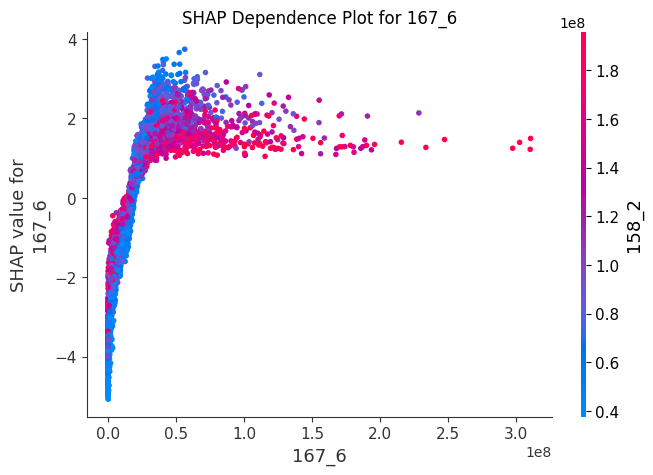

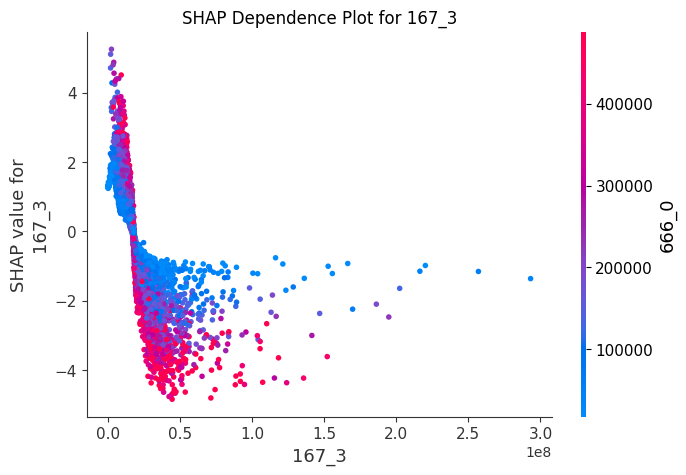

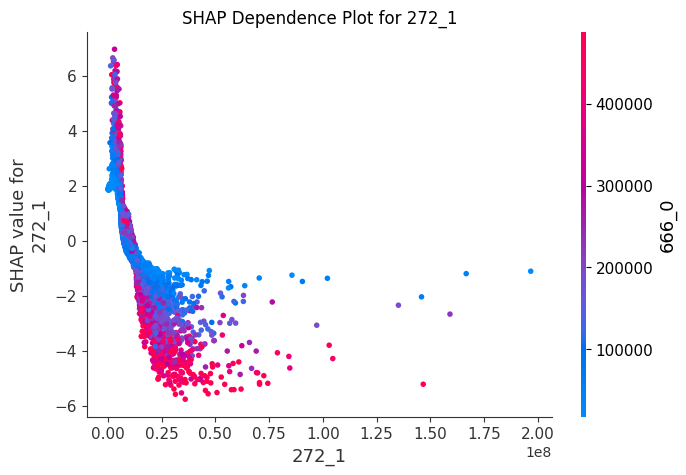

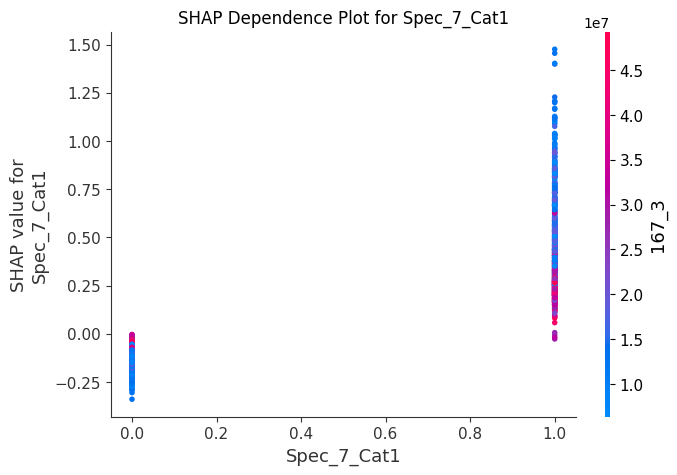

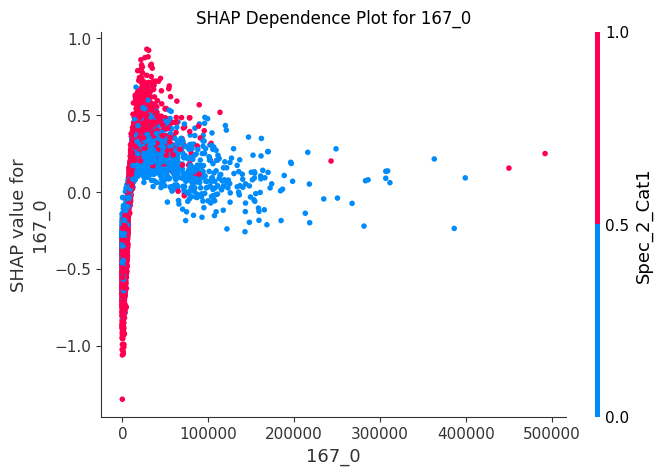

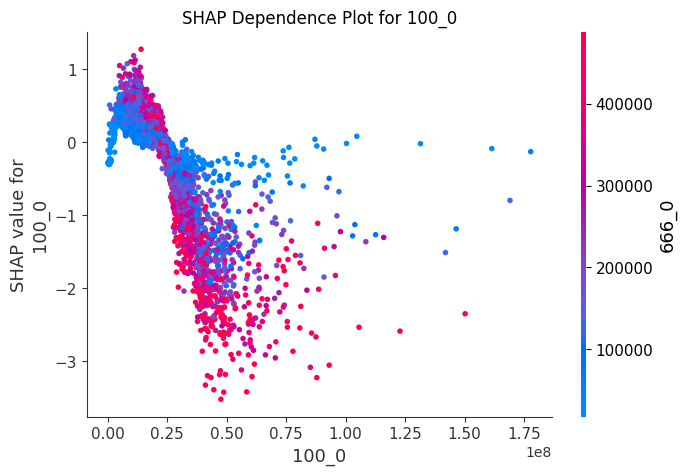

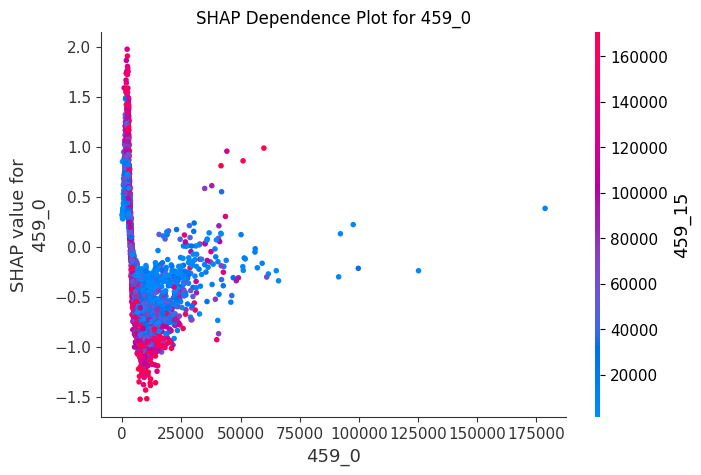

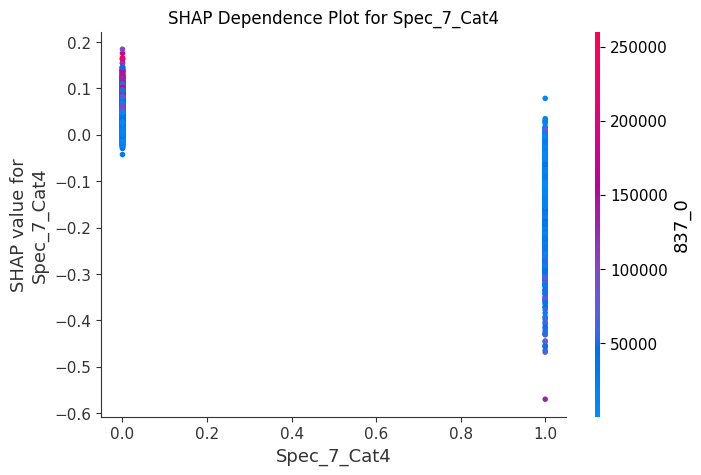

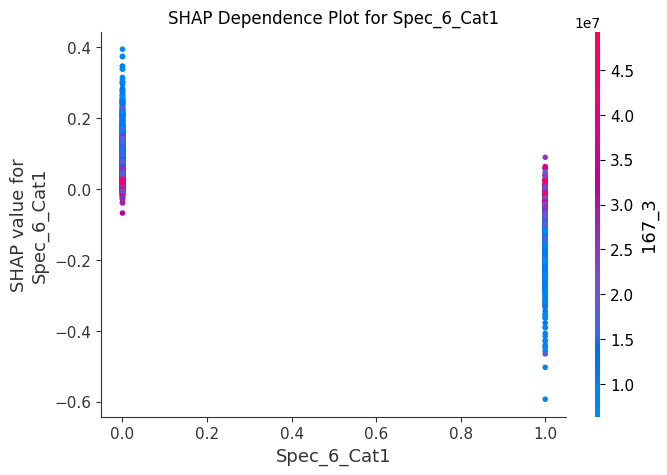

In [46]:
# Plot SHAP dependence plots for each feature
for feature_name in ['666_0', '837_0', '158_9', '167_2', '167_6', '167_3', '272_1', 'Spec_7_Cat1','167_0', '100_0', '459_0', 'Spec_7_Cat4', 'Spec_6_Cat1' ]:
    shap.dependence_plot(feature_name,shap_values, X_testt, show=False)
    plt.title(f'SHAP Dependence Plot for {feature_name}')
    plt.show()